In [1]:
import numpy as np
import pandas as pd
from src.models import get_belief_model
from scipy.special import expit
import pymc as pm
import arviz as az
import json
import os
import seaborn as sns
from src.models import get_belief_model


use_cpu = False

def make_dir(newpath):
    if not os.path.exists(newpath):
        os.makedirs(newpath)
make_dir('./out/')
make_dir('./out/posteriors/')


try: 
    from jax.lib import xla_bridge
    import matplotlib.pyplot as plt
    print(xla_bridge.get_backend().platform)
    if xla_bridge.get_backend().platform == 'gpu':
        use_cpu = False
    import pymc.sampling.jax as pmjax
except:
    print("No JAX backend")
    use_cpu = True

params = json.load(open('params.json'))
np.random.seed(params['seed'])

%load_ext autoreload
%autoreload 2
%autosave 30

cpu


/opt/homebrew/anaconda3/envs/mlc/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Autosaving every 30 seconds


# Step One: Conceptual Analysis
Participants, from various countries, have been asked to rate their agreement with statements indicating their belief in climate change. Our conceptual model is that their pre-treatment level of belief may be influenced by their country of origin. We also believe that treatments may impact their level of belief. Higher degrees of belief will increase support for each of the items. 


# Step Two: Define Conceptual Space
Answers range from 0 to 100, inclusive. Our domain knowledge from previous work with slider-reporting, suggets that a non-trivial portion of participants will indicate full support (or disagreement) for some items. 

# Step Three: Construct summary statistics 
We will not aggregate the data across items, as we do not beleive answers to each item are exchangeable. We will, however, scale respones from 0-100 to 0-1. 

# Step Four: Model Development
The potential over-dispersion and nature of the resopnse suggests a Zero-One inflated distribution. Moreover, the boundaries at zero and one make a Beta distribution a candidate for the continuous responses. This leads us to a zero-one inflated beta distribution (ZOIB). We will jointly model the mean continuous response, and the probabilty of selecting 100% as a hierachichal regression.

\begin{align}
y_i&\sim\text{ZOIB}(\mu_i, \kappa, \theta, \tau_i)\\
\mu_i&=\text{invlogit}(\text{Belief}_i)\\
\tau_i&=\text{invlogit}(\text{Belief}_i)\\
\theta_i&=\text{invlogit}(\alpha_\theta + \beta_\theta \times |\text{Belief}_i|)\\
\alpha_\theta&\sim\text{Cauchy}(-2,2)\\
\beta_\theta&\sim\text{Cauchy}(0,2)\\
\text{Belief}_i&=P_{p[i]} + I_i + T_{t[i], 0} + T_{t[i], 1} \times (P_{p[i]} + I_i)\\
P_p&= C_{c[p]} + p_\sigma \times \hat{P}_{\text{p}}\\
C &\sim \text{Normal}(a, 1)\\
p_\sigma &\sim \text{Normal}(0,1)\\
\hat{P}_{\text{p}} &\sim \text{Normal}(0,1)\\
I&\sim\text{ZeroSumNormal}(\sigma_{\text{item}})\\
\sigma_{\text{item}}&\sim\text{Exponential}(3)\\
T_t&\sim\text{MVNormal} \big(\begin{bmatrix}0\\0\end{bmatrix},S\big) \text{... for t treatments}\\
S&=\big(\begin{matrix}\sigma_a & 0 \\ 0 & \sigma_b \end{matrix}\big) R \big(\begin{matrix}\sigma_a & 0 \\ 0 & \sigma_b \end{matrix}\big)\\
R &\sim{LKJCorr(1)}\\
\sigma_{\alpha} &\sim \text{Exponential}(3) \\
\sigma_{\beta} &\sim \text{Exponential}(6) \\
\kappa&\sim\text{Gamma}(7.5, 1)\\
a &\sim \text{Normal}(0,1)\\

\end{align}

Both the probability of selecting "100\%" and the average response are modeled using an inverse logistic function of a latent value $\text{Belief}_i$, for the $i^{th}$ observation. The belief for a given observation is assumed to be a function of a participants average belief, $P$, the item-level effects, $I$, a treatment Intercept and effect of the participants belief ($T$). Participants are modeled hierarchically within countries, both using non-centered parameterizations. Countries are partially pooled using a hyperprior, $\alpha$ for the mean. Treatment intercepts and slopes are modeled as a multivariate gaussain using a non-centered parameterization. Priors were tuned through prior predictive simulation.  


# Step Five: Construct Summary Statistics
We will qualitatively assess prior predictive plausibility using visual inspection of histograms. Given our data volume, our goal is to identify priors that encompass a range of plausible values without pushing too much mass out to the tails or concentrating it in the center. 

In [5]:
import pandas as pd
df = pd.read_excel(params['data']['location'])
df.head()

,ResponseId,Country,cond,condName,Intervention_order,Intro_Timer,Intervention_Timer,BELIEFcc,POLICYcc,SHAREcc,...,Climate_Emergency,Carbon_Pollution,Gender,Age,Edu,Politics2_1,Politics2_9,Income,MacArthur_SES,PerceivedSciConsensu_1
0,R_3KOO2oUWQNtKzrD,Algeria,8,PluralIgnorance,PolicySupport|SocialmediasharingPipedText|Beli...,7.074,28.758,100.00,64.666667,1.0,...,NaN,NaN,1.0,25.0,3.0,53.0,53.0,4.0,4.0,86.0
1,R_3OdqhjO2quQKaIx,Algeria,12,BindingMoral,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,32.089,27.999,73.25,58.111111,1.0,...,NaN,NaN,1.0,35.0,4.0,92.0,36.0,6.0,10.0,31.0
2,R_2QuK4DRmnWL9FXS,Algeria,10,DynamicNorm,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,17.598,54.658,3.00,56.555556,NaN,...,NaN,NaN,3.0,18.0,2.0,100.0,88.0,9.0,4.0,50.0
3,R_1DYkviJgtp5u6JV,Algeria,7,PsychDistance,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,10.951,299.309,90.75,95.555556,0.0,...,NaN,NaN,1.0,32.0,3.0,93.0,82.0,2.0,3.0,4.0
4,R_1rqWNg0k27FgrE4,Algeria,12,BindingMoral,PolicySupport|BeliefinAnthrCC|Socialmediashari...,5.465,7.302,76.50,67.250000,0.0,...,NaN,NaN,2.0,29.0,4.0,NaN,NaN,3.0,7.0,100.0


In [ ]:
params = json.load(open('params.json'))
params['belief']['priors']

In [ ]:
from src.models import get_belief_model
model, df, sorted_df = get_belief_model(df, params['belief']['priors'])
pm.model_to_graphviz(model)

# Step Six: Simulate Bayesian Ensemble

With our priors and model loaded, we can simulate the implications of our structure and prior choice to determine whether we have chosen appropriate priors. Should they appear off, they can be adjusted in `params.json` and reloaded. 


In [ ]:
with model: 
    prior_predictive = pm.sample_prior_predictive(samples = params['belief']['prior_predictive_samples'],
                                                  random_seed=params['seed'])

az.to_netcdf(prior_predictive, './out/posteriors/prior_predictive_belief.nc')

# Step seven: Prior Predictive Checks
Here, we verify that our prior choices produce distributions of belief consistent with our domain knowledge. Specifically, we'd like to make sure that there is some inflation, but that a wide range of possible distributions emerge

In [ ]:
prior_pd = prior_predictive.prior_predictive['y_out']

plt.figure(figsize=(15, 15))
g = plt.GridSpec(5, 5, hspace=0.6, wspace=0.6)

for i in range(5):
    for j in range(5):
        ax = plt.subplot(g[i, j])
        sns.histplot(prior_pd[0, np.random.choice(np.arange(prior_pd.shape[1])), :], bins=np.linspace(-.0, 1.0, 21))
plt.tight_layout()



# Step Eight: Configure Algorithm
We will use default parameters to sample on the GPU. Tune and Draw can be adjusted in params.json

# Step Nine: Fit Simulated Ensemble
As this is computatioanlly challenging, we face some trade-offs between running the model at the full data volume and running the model on sufficient numbers of prior samples to draw conclusions about the inferential adequacy. We will fit our model six times to prior predictive data, and iteratively gain insight from those fits.  

Our goal is to ensure that the model samples cleanly (i.e., good RHat, BFMI, no divergences) and that our posterior distributions adequately represent our prior parameter choices. In working through this step, we adjust the model and priors based on pathologies that emerge. Overall, this step allows us to validate our full model is operating as expected, under ideal conditiosn where it is the true data generating process and parmaters are within the prior distribution.  In working through this step, we noticed early choices of priors were overly restrictive for some parameters leading to divergent transitions and biased inference. 



In [ ]:
#Add zero constrain on control treatment effects. 
from src.models import transform_y_for_gpu_ZOIB
from pymc.sampling import jax as pmjax

prior_num = 0
ranked_data = []
for prior_num in np.random.choice(np.arange(params['belief']['prior_predictive_samples']), size=6, replace=False):
    print('Running inference on prior sample: ', prior_num)
    with model:
        model.set_data('y', transform_y_for_gpu_ZOIB(prior_predictive.prior_predictive['y_out'].data[0][prior_num]))
        if use_cpu:
            idata = pm.sample(tune = params['belief']['tune'], draws = params['belief']['draws'], random_seed=params['seed'])
        else: 
            idata = pmjax.sample_numpyro_nuts(chain_method=params['sampling']['chain_method'],
                                        postprocessing_backend=params['sampling']['postprocessing_backend'], 
                                        tune =params['belief']['tune'], 
                                        chains=4,
                                        draws = params['belief']['draws'], random_seed=params['seed'])
        
        out = []
        var_names = ['u_t', 'country', 'a', 'item']
        for name in var_names:
            ranks = (prior_predictive.prior[name].data[0, prior_num] < idata.posterior[name]).sum(dim='chain').sum(dim='draw')
            means =idata.posterior[name].mean(dim=['chain', 'draw'])
            sd = idata.posterior[name].std(dim=['chain', 'draw'])
            prior_var = prior_predictive.prior[name].var(dim=['chain', 'draw'])
            prior_sd = prior_predictive.prior[name].std(dim=['chain', 'draw'])
            prior_mu= prior_predictive.prior[name].mean(dim=['chain', 'draw'])
            prior = prior_predictive.prior[name].data[0, prior_num] 
            var = idata.posterior[name].var(dim=['chain', 'draw'])
            out.append({'name':np.repeat(name, ranks.size),
                        'prior_num':np.repeat(prior_num, ranks.size),
                        'rank':ranks.values.ravel(),
                        'means':means.values.ravel(), 
                        'sd':sd.values.ravel(),
                        'var':var.values.ravel(),
                        'prior_var':prior_var.values.ravel(),
                        'prior_sd':prior_sd.values.ravel(),
                        'prior':prior.ravel(),
                        'prior_mu':prior_mu.values.ravel()})
        ranked_data.append(pd.concat(pd.DataFrame(x) for x in out))

        print('BFMI:')
        print(az.bfmi(idata))
        print('Rhat:')
        print(np.sum(az.summary(idata, var_names=var_names)['r_hat'] > 1.05))
        print('ess_bulk: min')
        print(np.sum(az.summary(idata, var_names=var_names)['ess_bulk'].min()))
        print('ess_tail: min')
        print(np.sum(az.summary(idata, var_names=var_names)['ess_tail'].min()))
        print('Divergeneces:')
        print(idata.sample_stats['diverging'].sum())
        #idata = pm.sample(tune = params['belief']['tune'], draws = params['belief']['draws'], random_seed=params['seed']) 

        pd.concat(ranked_data).to_csv('./out/belief_prior_ranks2.csv')
    print('-------------------------------------')

# Step Ten: Algorithmic Calibration

The adjustments to our prior model appear to have been sufficient to ensure healthy computation. We see no issues with eBFMI, divergences, or r_hat. 

# Step Eleven: Inferential Calibration

Examining the posterior predictive contraction vs. z-scores of known parameters is strongly clustered on the right of the graph near zero, with few extreme observations. This suggests adequate model fit, balancing overfit and underfit, and priors that are not causing the model to behave poorly. We will continue fitting the model. 


This leaves us to check the ensemble behavior of our recovered posterior distributions which looks reasonable for both parameters.

In [ ]:
df_temp = pd.read_csv('./out/belief_prior_ranks2.csv')


In [ ]:

df_temp['z_score'] = (df_temp['means']-df_temp['prior'])/df_temp['prior_sd']
df_temp['contraction'] = 1-df_temp['var']/df_temp['prior_var']

df_temp=df_temp[df_temp['means']!=0]
plt.scatter(df_temp['contraction'], df_temp['z_score'], alpha=.2)
plt.xlim(0,1)
plt.ylim(-4, 4)
plt.xlabel('Posterior Contraction')
plt.ylabel('Posterior Z-Score')

# Step Twelve: Fit the Observation

Confident in the performance of the expanded model within the scope of its own assumptions we go back to fit the observed data once again, this time taking the zero-inflation into account in our posterior predictive simulations.

In [2]:
#reload data, parameters

params = json.load(open('params.json'))
df = pd.read_excel(params['data']['location'])
df.head()


,ResponseId,Country,cond,condName,Intervention_order,Intro_Timer,Intervention_Timer,BELIEFcc,POLICYcc,SHAREcc,...,Climate_Emergency,Carbon_Pollution,Gender,Age,Edu,Politics2_1,Politics2_9,Income,MacArthur_SES,PerceivedSciConsensu_1
0,R_3KOO2oUWQNtKzrD,Algeria,8,PluralIgnorance,PolicySupport|SocialmediasharingPipedText|Beli...,7.074,28.758,100.00,64.666667,1.0,...,NaN,NaN,1.0,25.0,3.0,53.0,53.0,4.0,4.0,86.0
1,R_3OdqhjO2quQKaIx,Algeria,12,BindingMoral,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,32.089,27.999,73.25,58.111111,1.0,...,NaN,NaN,1.0,35.0,4.0,92.0,36.0,6.0,10.0,31.0
2,R_2QuK4DRmnWL9FXS,Algeria,10,DynamicNorm,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,17.598,54.658,3.00,56.555556,NaN,...,NaN,NaN,3.0,18.0,2.0,100.0,88.0,9.0,4.0,50.0
3,R_1DYkviJgtp5u6JV,Algeria,7,PsychDistance,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,10.951,299.309,90.75,95.555556,0.0,...,NaN,NaN,1.0,32.0,3.0,93.0,82.0,2.0,3.0,4.0
4,R_1rqWNg0k27FgrE4,Algeria,12,BindingMoral,PolicySupport|BeliefinAnthrCC|Socialmediashari...,5.465,7.302,76.50,67.250000,0.0,...,NaN,NaN,2.0,29.0,4.0,NaN,NaN,3.0,7.0,100.0


In [3]:
from src.models import get_belief_model
model, df, temp = get_belief_model(df, params['belief']['priors'])

In [7]:
if params['belief']['resample'] and os.path.exists(params['belief']['idata_location']):
    idata_belief = az.from_netcdf(params['belief']['idata_location'])
else:
    with model:
        if use_cpu: 
            idata = pm.sample(cores = params['sampling']['cores'], 
                            tune = params['belief']['tune'],
                            draws = params['belief']['draws'], 
                            random_seed=params['seed'], 
                            target_accept=params['belief']['target_accept'])
        else:
             idata = pmjax.sample_numpyro_nuts(chain_method=params['sampling']['chain_method'],
                                            postprocessing_backend='cpu', 
                                            tune = params['belief']['tune'],
                                            draws = params['belief']['draws'], random_seed=params['seed'])
    if params['belief']['save_model_fitting_ipynb']:
        az.to_netcdf(idata, params['belief']['idata_location'])

Compiling...
Compilation time =  0:00:08.598418
Sampling...


warmup:   1%|          | 16/3000 [09:14<55:36:21, 67.08s/it]

# Step Thirteen: Diagnose Posterior Fit

In [ ]:
idata.sample_stats['diverging'].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [ ]:
az.bfmi(idata)

array([0.62315362, 0.59926699, 0.66719385, 0.60366212])

In [ ]:
az.summary(idata, var_names=['u_t', 'country', 'a',
                              'item','kappa']).sort_values('ess_bulk', ascending=True)

/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"u_t[NormativeAppeal, Intercept]",-0.075,0.032,-0.132,-0.011,0.004,0.003,54.0,545.0,1.08
kappa,8.088,0.038,8.014,8.156,0.005,0.003,67.0,2122.0,1.04
country[Norway],1.144,0.053,1.052,1.248,0.005,0.004,113.0,539.0,1.04
country[Greece],1.469,0.067,1.346,1.593,0.006,0.004,146.0,550.0,1.04
"u_t[SciConsens, Intercept]",0.019,0.032,-0.040,0.080,0.002,0.002,195.0,683.0,1.03
...,...,...,...,...,...,...,...,...,...
"u_t[aaControl, Slope]",0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
"u_t[aaControl, Intercept]",0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
item[Belief2],0.025,0.003,0.020,0.030,0.000,0.000,4494.0,2711.0,1.00
item[Belief3],0.040,0.003,0.035,0.045,0.000,0.000,5783.0,3062.0,1.00


In [ ]:
az.summary(idata, var_names=['u_t', 'country', 'a',
                              'item','kappa','alpha_theta', 'beta_theta']).sort_values('ess_tail', ascending=True)

/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
country[Germany],1.608,0.047,1.518,1.696,0.003,0.002,253.0,373.0,1.03
country[Morocco],1.667,0.070,1.531,1.796,0.004,0.003,354.0,409.0,1.03
country[Belgium],1.339,0.053,1.229,1.429,0.003,0.002,300.0,444.0,1.02
country[Australia],1.434,0.053,1.339,1.534,0.003,0.002,270.0,474.0,1.02
country[New Zealand],1.312,0.052,1.209,1.404,0.003,0.002,278.0,484.0,1.02
...,...,...,...,...,...,...,...,...,...
item[Belief1],-0.064,0.003,-0.069,-0.059,0.000,0.000,3821.0,2808.0,1.01
item[Belief4],-0.001,0.003,-0.006,0.004,0.000,0.000,6538.0,2966.0,1.00
item[Belief3],0.040,0.003,0.035,0.045,0.000,0.000,5783.0,3062.0,1.00
"u_t[aaControl, Slope]",0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN


/home/ubuntu/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<AxesSubplot: ylabel='country\nNetherlands'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='country\nSwitzerland'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='country\nUSA'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='country\nItaly'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='country\nTanzania'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='country\nSweden'>, <AxesSubplot: >,
 

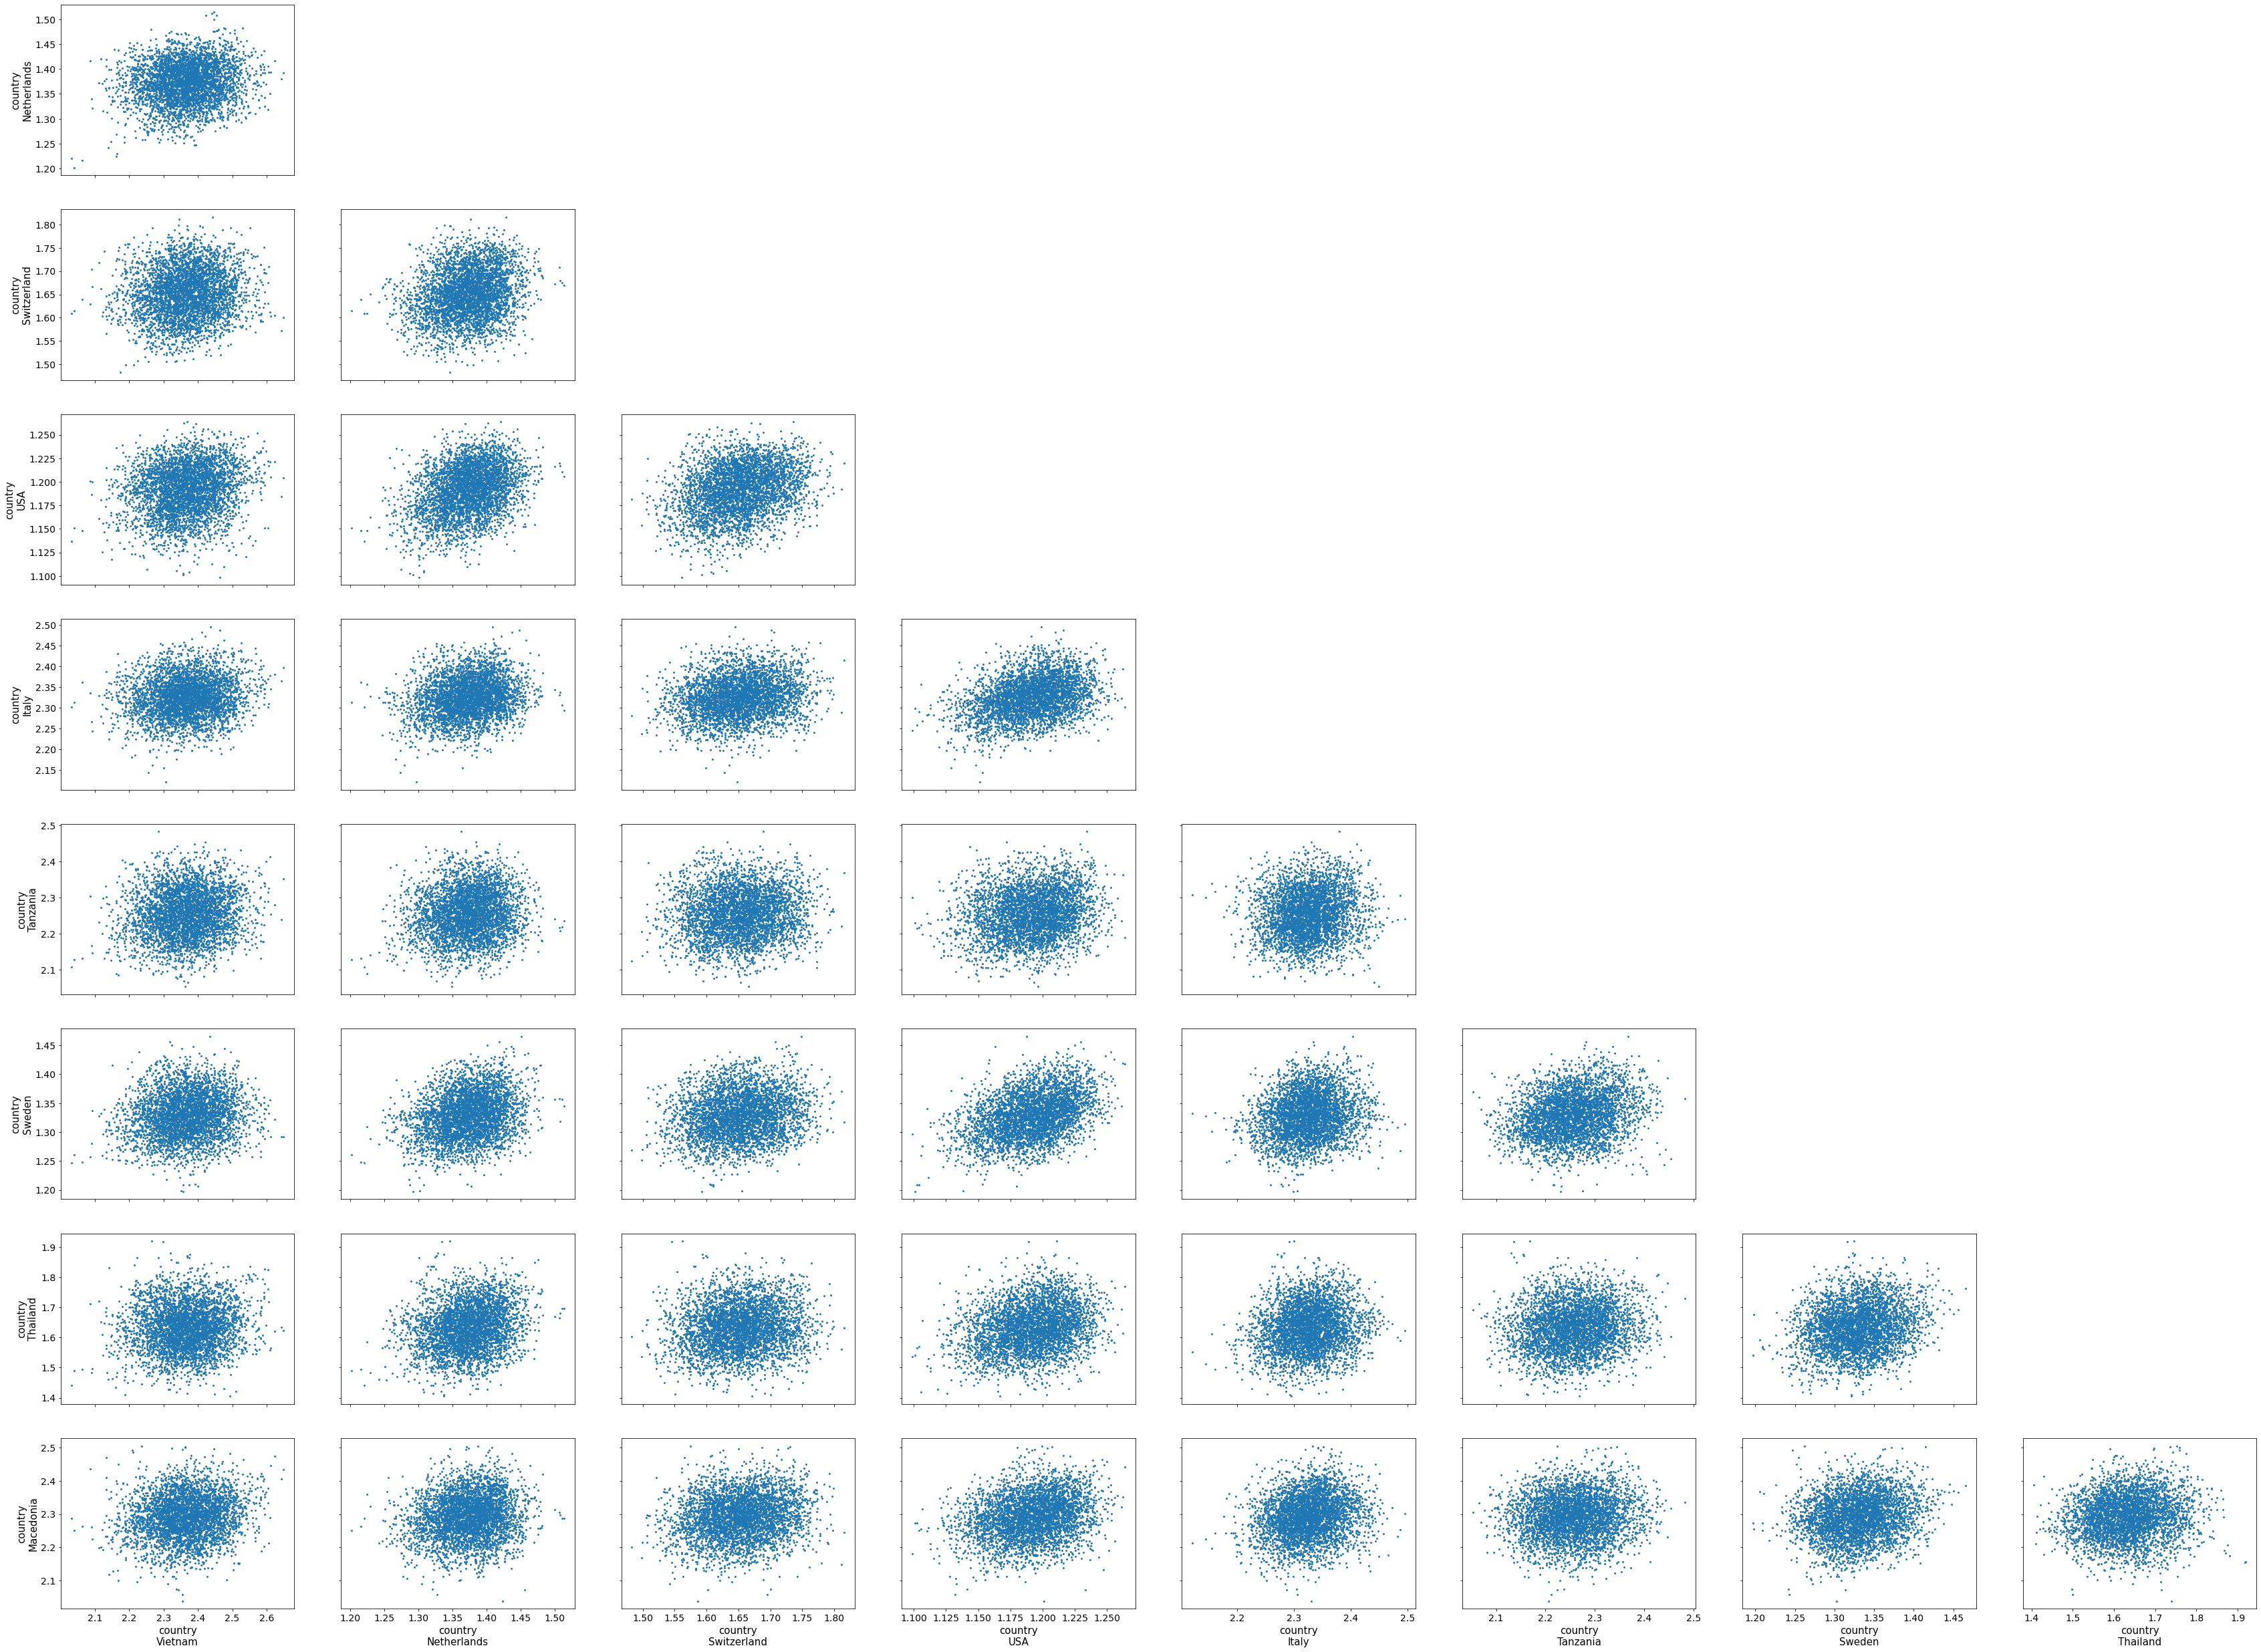

In [ ]:
az.plot_pair(idata, var_names='country')

In [ ]:
az.summary(idata, var_names=['u_t', 'country', 'a',
                              'item','kappa', 'alpha_theta', 'beta_theta']).sort_values('r_hat', ascending=False)

/home/ubuntu/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"u_t[NormativeAppeal, Intercept]",-0.075,0.032,-0.132,-0.011,0.004,0.003,54.0,545.0,1.08
kappa,8.088,0.038,8.014,8.156,0.005,0.003,67.0,2122.0,1.04
country[Greece],1.469,0.067,1.346,1.593,0.006,0.004,146.0,550.0,1.04
country[Saudi Arabia],0.975,0.082,0.829,1.140,0.006,0.004,219.0,581.0,1.04
country[Norway],1.144,0.053,1.052,1.248,0.005,0.004,113.0,539.0,1.04
...,...,...,...,...,...,...,...,...,...
item[Belief2],0.025,0.003,0.020,0.030,0.000,0.000,4494.0,2711.0,1.00
country[Serbia],2.431,0.092,2.261,2.605,0.004,0.003,429.0,789.0,1.00
"u_t[LetterFuture, Slope]",0.006,0.013,-0.017,0.030,0.000,0.000,771.0,1378.0,1.00
"u_t[aaControl, Intercept]",0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN


#  Step Fourteen: Posterior Retrodictive Fit

In [ ]:
with model:
   ppc = pm.sample_posterior_predictive(idata, var_names=["y_out", "participant"])
idata.extend(ppc)

Sampling: [y_out]


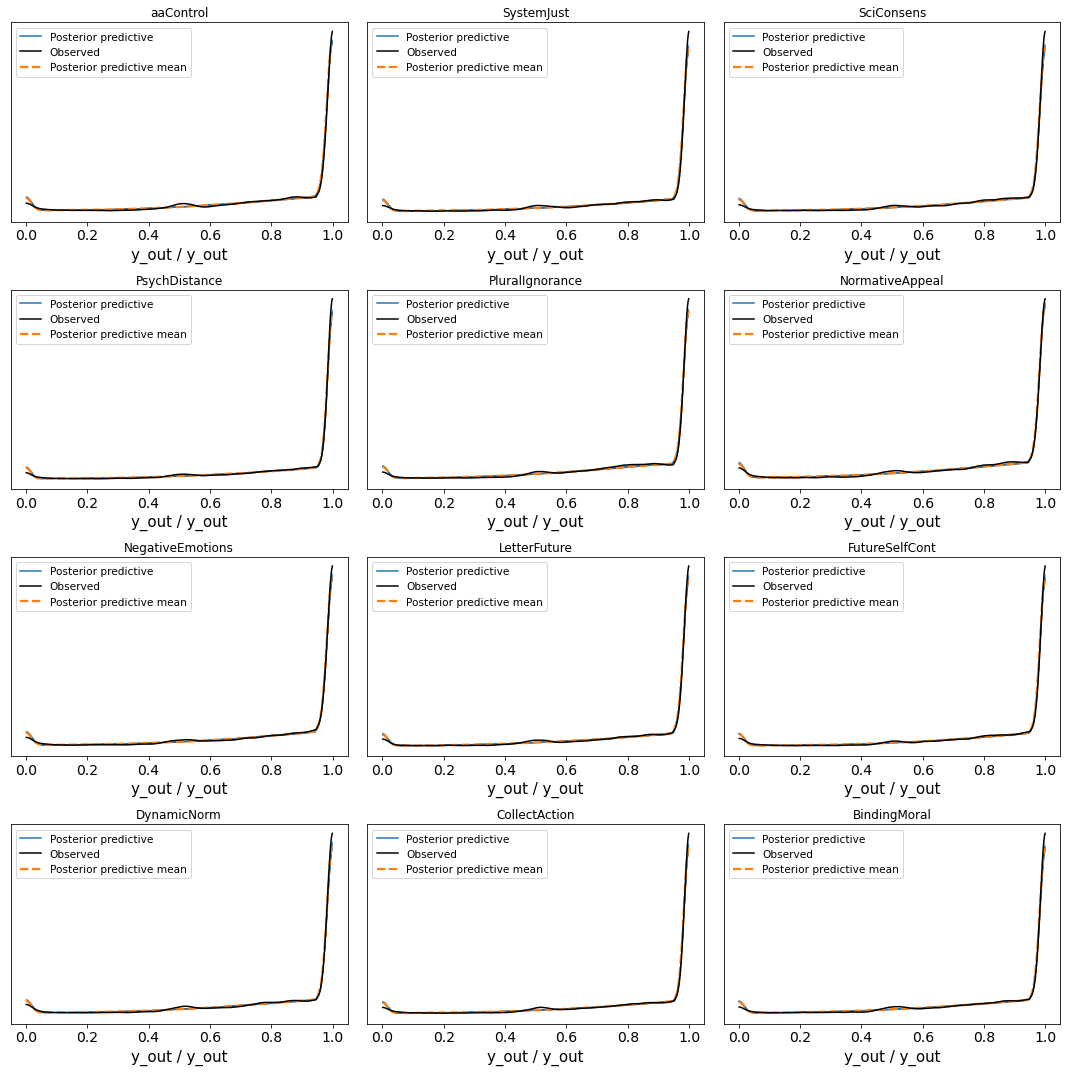

In [ ]:
idata.rename({'y_out_dim_0':'obs_id', 'y_out_dim_2':'obs_id'}, inplace=True)
idata = idata.assign_coords(obs_id=temp['condName'].values,  groups="observed_vars")

g = plt.GridSpec(4, 3, figure=plt.figure(figsize=(15, 15)))

condName = temp['condName'].unique()[0]
for i, condName in enumerate(temp['condName'].unique()):
    ax = plt.subplot(g[i//3, i%3])
    az.plot_ppc(idata, coords={'obs_id': [condName]}, num_pp_samples=50, ax=ax)
    ax.set_title(condName)
plt.tight_layout()

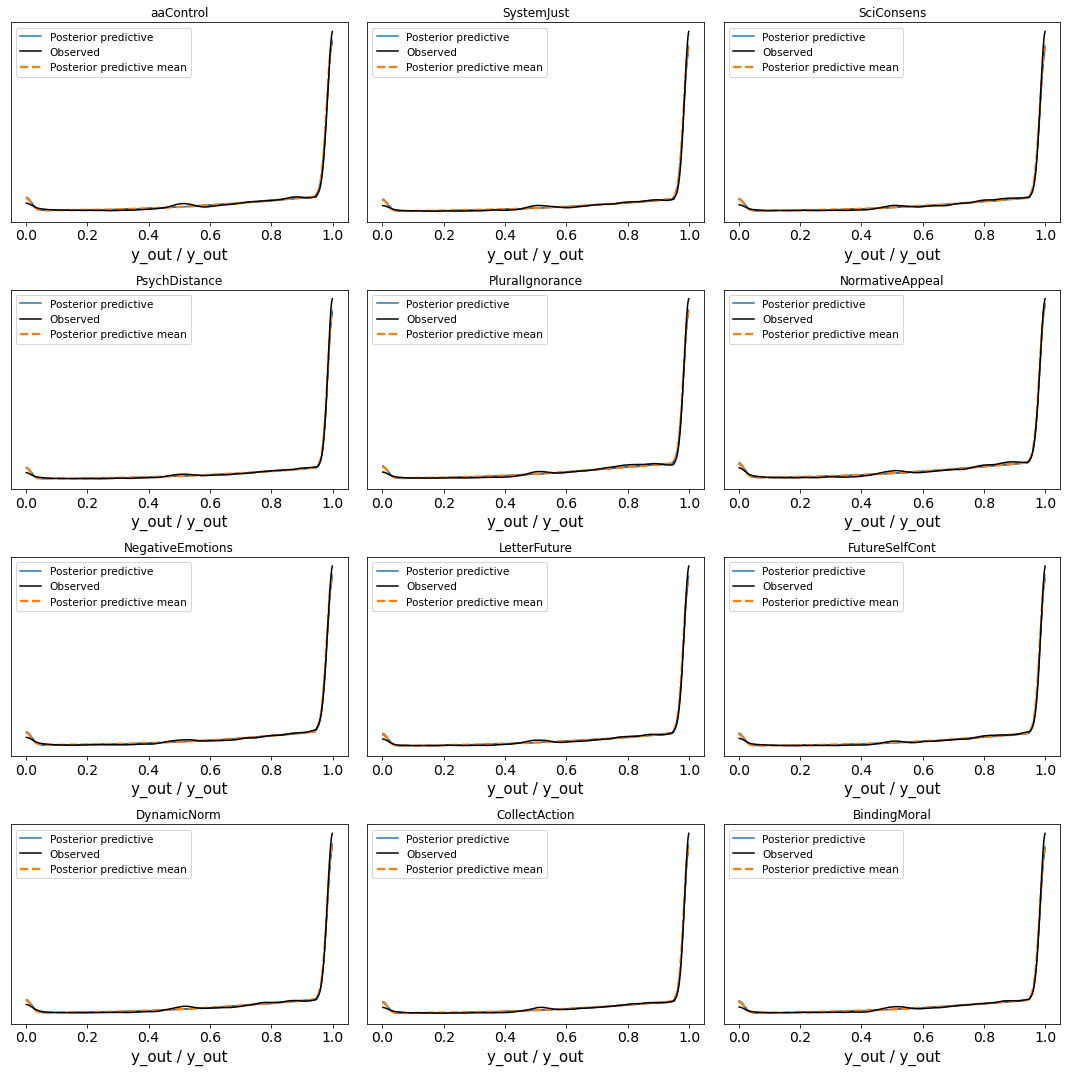

In [ ]:
g = plt.GridSpec(4, 3, figure=plt.figure(figsize=(15, 15)))

condName = temp['condName'].unique()[0]
for i, condName in enumerate(temp['condName'].unique()):
    ax = plt.subplot(g[i//3, i%3])
    az.plot_ppc(idata, coords={'obs_id': [condName]}, num_pp_samples=50, ax=ax)
    ax.set_title(condName)
plt.tight_layout()

In [ ]:
temp['y_hat'] = 100 * idata.posterior_predictive['y_out'].median(dim=('chain', 'draw'))

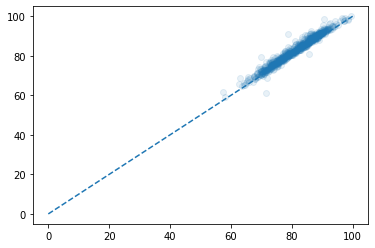

In [ ]:
temp['y_hat'] = 100 * idata.posterior_predictive['y_out'].median(dim=('chain', 'draw'))
plt.scatter(temp.groupby(['condName', 'Country'])['Belief'].mean().values, 
           temp.groupby(['condName', 'Country'])['y_hat'].mean().values, alpha=.1)
plt.plot([0, 100], [0, 100], ls='--')

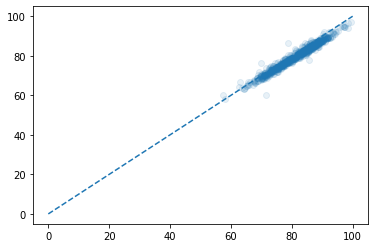

In [ ]:
temp['y_hat'] = 100 * idata.posterior_predictive['y_out'].mean(dim=('chain', 'draw'))
plt.scatter(temp.groupby(['condName', 'Country'])['Belief'].mean().values, 
           temp.groupby(['condName', 'Country'])['y_hat'].mean().values, alpha=.1)
plt.plot([0, 100], [0, 100], ls='--')

In [39]:
df[df['condName']=='Control'].groupby('Country')['BELIEFcc'].median().mean()

86.74166666666666

In [40]:
expit(idata.posterior['a'].median())

<xarray.DataArray 'a' ()>
array(0.86407046)

# Create Adjusted Belief dataset

In [41]:
adj_belief_df = pd.DataFrame({'UniqueID':idata.posterior['participant'].coords['participants'].values,
              'BeliefADJ':idata.posterior['participant'].median(axis=(0,1))})

adj_df = pd.merge(df, adj_belief_df, on='UniqueID', how='left', validate='one_to_many')
adj_df.to_excel('./dat/data60_adj.xlsx')